In [1]:
import pandas as pd
import networkx as nx
import pygraphviz as pgv
from shortest_path import SignedPathSolver
from pagerank import PageRankSolver
import time
from upsetplot import plot
from matplotlib import pyplot as plt
import os
import itertools
import numpy as np
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr


# Trynska data

## Shortest path

In [2]:
collectri = pd.read_csv('network_collectri.sif', sep='\t')
data_col = collectri.pop('data')
collectri.insert(2, 'data', data_col)
collectri.rename(columns={'source': '# source'}, inplace=True)
collectri.to_csv('collectri_network_sscp.sif', sep='\t', index=None)
collectri

,# source,target,data
0,CALM1,TRPC1,-1
1,CALM3,TRPC1,-1
2,CALM2,TRPC1,-1
3,CAV1,TRPC1,1
4,MDFI,TRPC1,-1
...,...,...,...
81749,NFKB,hsa-miR-143-3p,1
81750,AP1,hsa-miR-206,1
81751,NFKB,hsa-miR-21-5p,1
81752,NFKB,hsa-miR-224-5p,1


In [3]:
target_df = pd.read_csv('downstream_hits.tsv', sep='\t', header=None)
target_df.drop(1, inplace=True, axis=1)
target_df

,0,2
0,CINP,+
1,ATP1B1,+
2,DNAJC12,+
3,SCCPDH,+
4,IDS,+
...,...,...
95,IKZF1,-
96,SDHD,+
97,RASGRP3,+
98,BIRC6,-


In [4]:
target_df[2].replace({'+': 1, '-': -1}, inplace=True)

target_dict = target_df.set_index(0)[2].to_dict()


In [6]:
G = nx.read_weighted_edgelist('collectri_network_sscp.sif', delimiter = '\t', create_using = nx.DiGraph)

# 2. Iterate through each edge and 3. Set attributes
for u, v, data in G.edges(data=True):
    weight = data['weight']
    data['sign'] = 1 if weight >= 0 else -1
    data['weight'] = abs(weight)

G.get_edge_data('TGFB1', 'KLF2') #none

In [7]:
# Removes targets not present in the network
filtered_target_dict = {key: value for key, value in target_dict.items() if key in G.nodes()}

In [8]:
len(filtered_target_dict)

49

In [9]:
G_solver = SignedPathSolver(G)
G_solver.source_dict = {'TGFB1': 1, 'TGFB2': 1, 'TGFB3': 1, 'IL2': 1}
G_solver.target_dict = filtered_target_dict


## PageRank

In [10]:
P_solver = PageRankSolver(G)
P_solver.source_dict = {'TGFB1': 1, 'TGFB2': 1, 'TGFB3': 1, 'IL2': 1}
P_solver.target_dict = filtered_target_dict

In [11]:
P_solver.pagerank_solver(personalize_for='source')

In [12]:
P_solver.pagerank_solver(personalize_for='target')

In [142]:

threshold = 0.01
targets_from_paths = []
runinfo_dict = {}

# get non-pagerank solvers' info
start_time = time.time()
shortest_paths, runinfo = G_solver.shortest_paths(label = 'shortest_path')
end_time = time.time()
computation_time = end_time - start_time
runinfo_dict.update(runinfo)
runinfo_dict['shortest_path'].update({'computation_time': computation_time})
targets_from_paths = {path[-1] for path in G_solver.shortest_paths_res if len(path) > 1}
runinfo_dict['shortest_path'].update({'targets_connected': len(targets_from_paths)})
G_solver.visualize_graph("shortest_path", is_sign_consistent=False, export_sif=True)

start_time = time.time()
shortest_sc_paths, runinfo = G_solver.sign_consistency_check('shortest_sc_path')
end_time = time.time()
computation_time = end_time - start_time
runinfo_dict.update(runinfo)
runinfo_dict['shortest_sc_path'].update({'computation_time': computation_time})
targets_from_paths = {path[-1] for path in G_solver.shortest_sc_paths_res if len(path) > 1}
runinfo_dict['shortest_sc_path'].update({'targets_connected': len(targets_from_paths)})
G_solver.visualize_graph("shortest_sc_path", is_sign_consistent=True, export_sif=True)

while len(targets_from_paths) < len(filtered_target_dict)-3:
    
    P_solver.threshold = threshold
    threshold_label = f"pagerank_{threshold}"

    start_time = time.time()
    paths, runinfo = P_solver.compute_filtered_shortest_paths(label = threshold_label)
    end_time = time.time()

    targets_from_paths = {path[-1] for path in P_solver.shortest_paths_res if len(path) > 1}

    runinfo_dict.update(runinfo)

    runinfo_dict[threshold_label].update({'computation_time': computation_time})
    runinfo_dict[threshold_label].update({'targets_connected': len(targets_from_paths)})

    P_solver.visualize_pagerank(threshold_label, is_sign_consistent=False, export_sif=True)


    threshold_label = f"pagerank_sc_{threshold}"

    start_time = time.time()
    paths, runinfo = P_solver.sign_consistency_check(label = threshold_label)
    end_time = time.time()

    computation_time = end_time - start_time

    runinfo_dict.update(runinfo)
    runinfo_dict[threshold_label].update({'computation_time': computation_time})
    runinfo_dict[threshold_label].update({'targets_connected': len(targets_from_paths)})

    P_solver.visualize_pagerank(threshold_label, is_sign_consistent=True, export_sif=True)
    
    print(f"Threshold computed: {threshold}")

    threshold = round(threshold - 0.001, 3)


There were no sign consistent paths for the given perturbations and downstream effects.
Threshold computed: 0.01
Threshold computed: 0.009
Threshold computed: 0.008
Threshold computed: 0.007
Threshold computed: 0.006
Threshold computed: 0.005
Threshold computed: 0.004
Threshold computed: 0.003
Threshold computed: 0.002
Threshold computed: 0.001


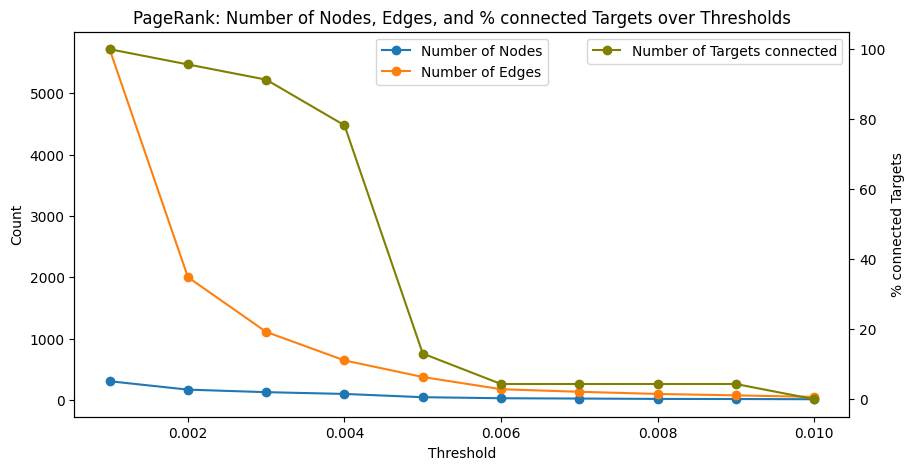

In [144]:
thresholds = list(runinfo_dict.keys())[2::2]
num_nodes = [runinfo_dict[t]['num_nodes'] for t in thresholds]
num_edges = [runinfo_dict[t]['num_edges'] for t in thresholds]
num_targets = [runinfo_dict[t]['targets_connected']/46*100 for t in thresholds]

thresholds_float = [float(t.split('_')[1]) for t in thresholds]

plt.figure(figsize=(10, 5))

# Primary y-axis (on the left)
ax1 = plt.gca()  # get the current axis
ax1.plot(thresholds_float, num_nodes, '-o', label="Number of Nodes")
ax1.plot(thresholds_float, num_edges, '-o', label="Number of Edges")
ax1.set_xlabel('Threshold')
ax1.set_ylabel('Count')
ax1.tick_params(axis='y')
ax1.legend(loc='upper center')

# Secondary y-axis (on the right)
ax2 = ax1.twinx()  # Create a twin y-axis sharing the same x-axis
ax2.plot(thresholds_float, num_targets, '-o', label="Number of Targets connected", color='olive')
ax2.set_ylabel('% connected Targets')
ax2.tick_params(axis='y')
ax2.legend(loc='upper right')

plt.title('PageRank: Number of Nodes, Edges, and % connected Targets over Thresholds')
plt.show()


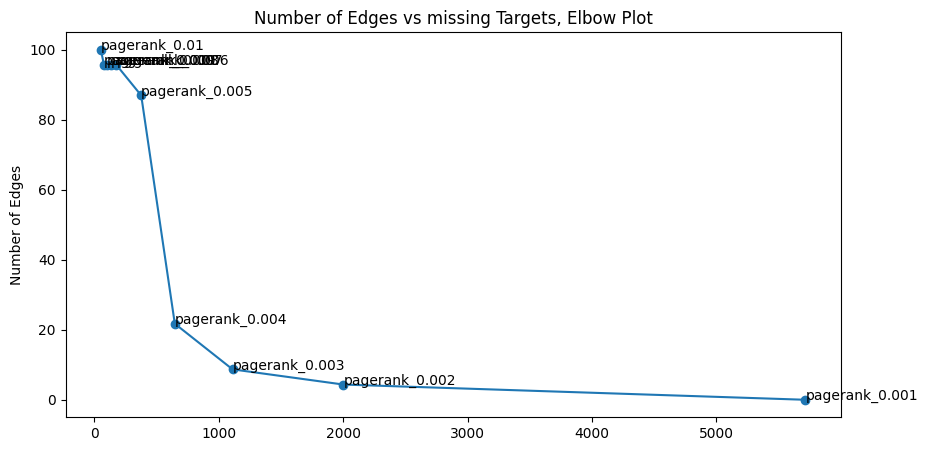

In [145]:
plt.figure(figsize=(10, 5))
ax = plt.gca()
missing_targets = [100-t for t in num_targets]
ax.plot(num_edges, missing_targets, '-o')
for t in thresholds:
    ax.text(num_edges[thresholds.index(t)], missing_targets[thresholds.index(t)], str(t))

plt.title('Number of Edges vs missing Targets, Elbow Plot')
plt.ylabel('% missing Targets')
plt.ylabel('Number of Edges')
plt.show()

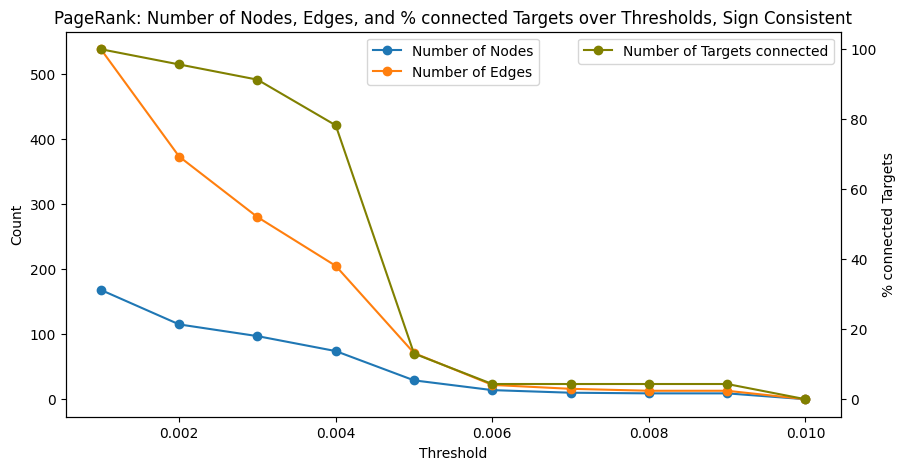

In [146]:
thresholds_sc = list(runinfo_dict.keys())[3::2]
num_nodes = [runinfo_dict[t]['num_nodes'] for t in thresholds_sc]
num_edges = [runinfo_dict[t]['num_edges'] for t in thresholds_sc]
num_targets = [runinfo_dict[t]['targets_connected']/46*100 for t in thresholds_sc]

thresholds_float = [float(t.split('_')[2]) for t in thresholds_sc]

plt.figure(figsize=(10, 5))

# Primary y-axis (on the left)
ax1 = plt.gca()  # get the current axis
ax1.plot(thresholds_float, num_nodes, '-o', label="Number of Nodes")
ax1.plot(thresholds_float, num_edges, '-o', label="Number of Edges")
ax1.set_xlabel('Threshold')
ax1.set_ylabel('Count')
ax1.tick_params(axis='y')
ax1.legend(loc='upper center')

# Secondary y-axis (on the right)
ax2 = ax1.twinx()  # Create a twin y-axis sharing the same x-axis
ax2.plot(thresholds_float, num_targets, '-o', label="Number of Targets connected", color='olive')
ax2.set_ylabel('% connected Targets')
ax2.tick_params(axis='y')
ax2.legend(loc='upper right')

plt.title('PageRank: Number of Nodes, Edges, and % connected Targets over Thresholds, Sign Consistent')
plt.show()

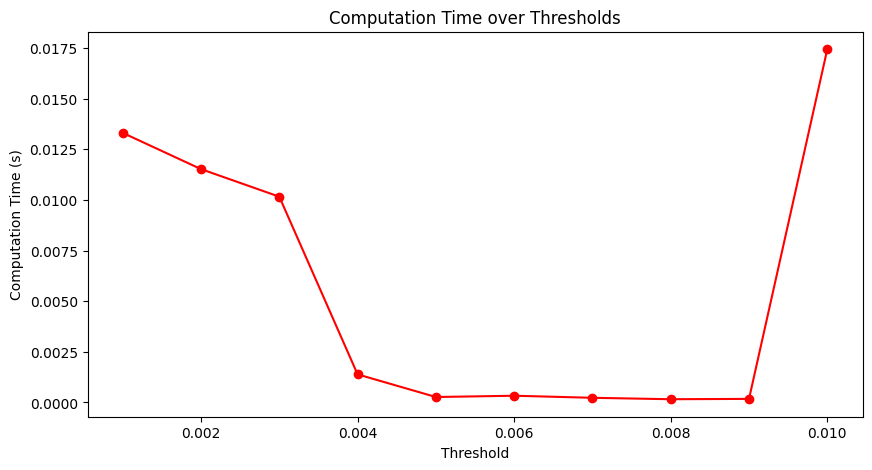

In [147]:

computation_times = [runinfo_dict[t]['computation_time'] for t in thresholds]
thresholds_float = [float(t.split('_')[1]) for t in thresholds]
plt.figure(figsize=(10, 5))
plt.plot(thresholds_float, computation_times, '-o', color="red")
plt.xlabel('Threshold')
plt.ylabel('Computation Time (s)')
plt.title('Computation Time over Thresholds')
plt.show()

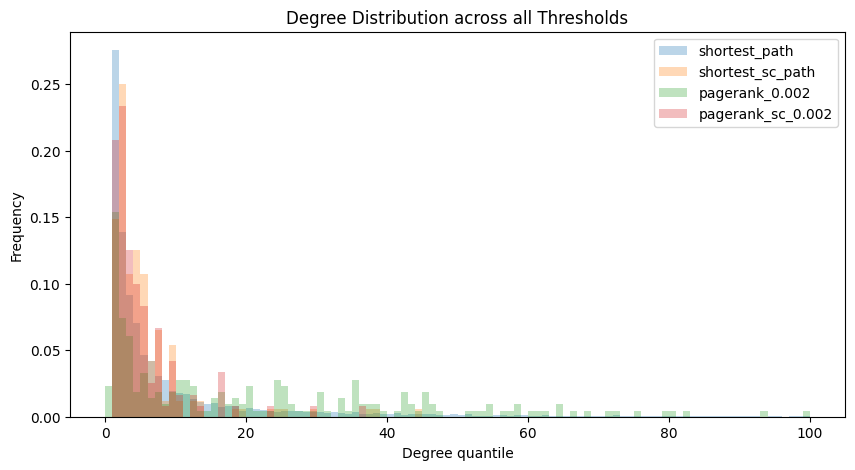

In [85]:


selected_thresholds = ['shortest_path', 'shortest_sc_path', 'pagerank_0.004', 'pagerank_sc_0.004']



plt.figure(figsize=(10, 5))
for threshold in selected_thresholds:
    data = runinfo_dict.get(threshold)  # Use `get` method to retrieve the data
    if data:  # This will check if data is not None
        norm_degrees = np.ones_like(data['degrees']) / len(data['degrees'])
        plt.hist(data['degrees'], label=threshold, alpha=0.3, bins=np.linspace(0, 100, 101), weights=norm_degrees)



plt.xlabel('Degree quantile')
plt.ylabel('Frequency')
plt.title('Degree Distribution across all Thresholds')
plt.legend(loc='upper right')
plt.show()


In [151]:
# Directory containing the sif files
directory = './'  # Change this to the path of your .sif files

is_sign_consistent = False

# Getting a list of all .sif files in the directory
expected_files = [threshold + ".sif" for threshold in selected_thresholds]
all_files = [f for f in os.listdir(directory) if f in expected_files]

# Parse the threshold from the filename
def get_threshold(filename):
    # Removing 'PageRank_' prefix and '.sif' suffix, then converting to float
    return filename.replace('.sif', '')

# Extracting edges from each file
edges_dict = {}
for file in all_files:
    path = os.path.join(directory, file)
    df = pd.read_csv(path, sep='\t')
    
    # Create unique edge representations
    edges = set(tuple(row) for index, row in df.iterrows())
    edges_dict[get_threshold(file)] = edges

# Creating a helper function to calculate intersection
def get_intersection_for_thresholds(thresholds):
    edge_sets = [edges_dict[thresh] for thresh in thresholds]
    return len(set.intersection(*edge_sets))

# This will generate the intersections and format the series as desired
intersection_dict = {}
for r in range(1, len(edges_dict.keys()) + 1):
    for combination in itertools.combinations(edges_dict.keys(), r):
        index_values = [threshold in combination for threshold in edges_dict.keys()]
        intersection_dict[tuple(index_values)] = get_intersection_for_thresholds(combination)


intersection_series = pd.Series(intersection_dict, )
intersection_series = intersection_series[intersection_series > 0]
intersection_series.index.names = combination


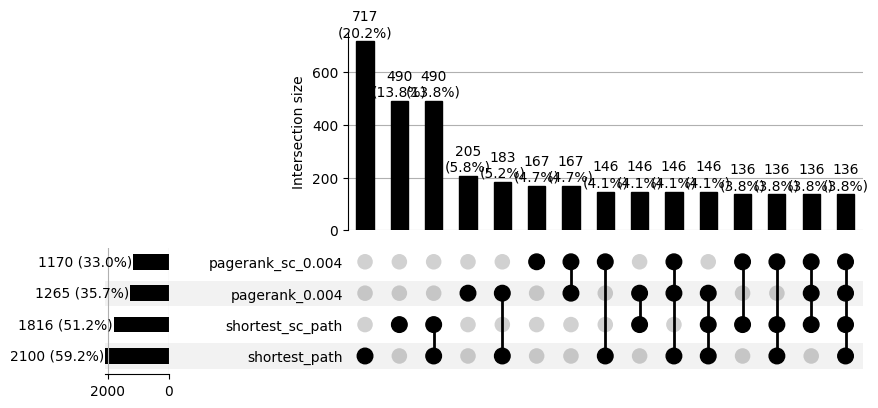

In [152]:



# Plot using upsetplot and use the created figure
plot(intersection_series, sort_by='cardinality', show_counts=True, show_percentages=True)
plt.show()

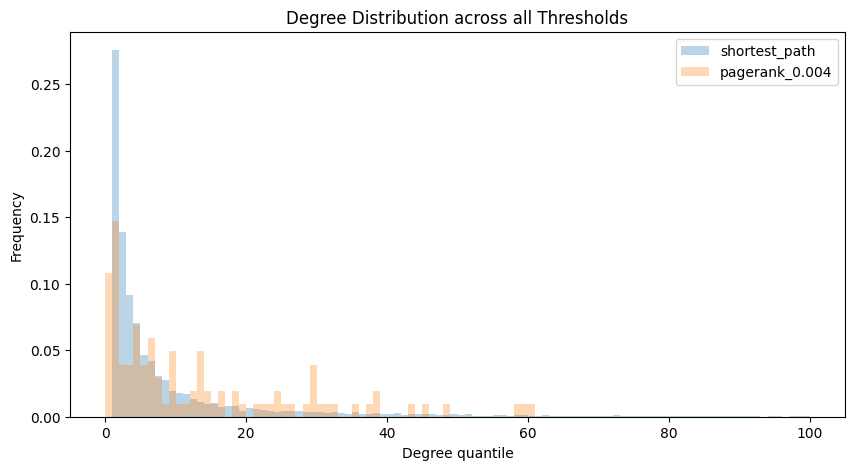

In [153]:
selected_thresholds = ['shortest_path', 'pagerank_0.004']



plt.figure(figsize=(10, 5))
for threshold in selected_thresholds:
    data = runinfo_dict.get(threshold)  # Use `get` method to retrieve the data
    if data:  # This will check if data is not None
        norm_degrees = np.ones_like(data['degrees']) / len(data['degrees'])
        plt.hist(data['degrees'], label=threshold, alpha=0.3, bins=np.linspace(0, 100, 101), weights=norm_degrees)



plt.xlabel('Degree quantile')
plt.ylabel('Frequency')
plt.title('Degree Distribution across all Thresholds')
plt.legend(loc='upper right')
plt.show()


# GSE106159

The goals of this study are to compare the U87 cell xenograft GBM mice (U87 cell line) to TWIST1 knock out U87 cell xenograft GBM mice (TWIST1 knock out U87 cell line) using their transcriptomes. 

TWIST1 (TW) is a bHLH transcription factor (TF) and master regulator of the epithelial‐to‐mesenchymal transition (EMT). In vitro, TW promotes mesenchymal change, invasion, and self‐renewal in glioblastoma (GBM) cells. However, the potential therapeutic relevance of TW has not been established through loss‐of‐function studies in human GBM cell xenograft models. The effects of TW loss of function (gene editing and knockdown) on inhibition of tumorigenicity of U87MG and GBM4 glioma stem cells were tested in orthotopic xenograft models and conditional knockdown in established flank xenograft tumors. RNAseq and the analysis of tumors investigated putative TW‐associated mechanisms. Multiple bioinformatic tools revealed significant alteration of ECM, membrane receptors, signaling transduction kinases, and cytoskeleton dynamics leading to identification of PI3K/AKT signaling. We experimentally show alteration of AKT activity and periostin (POSTN) expression in vivo and/or in vitro. For the first time, we show that effect of TW knockout inhibits AKT activity in U87MG cells in vivo independent of PTEN mutation. The clinical relevance of TW and candidate mechanisms was established by analysis of the TCGA and ENCODE databases. TW expression was associated with decreased patient survival and LASSO regression analysis identified POSTN as one of top targets of TW in human GBM. While we previously demonstrated the role of TW in promoting EMT and invasion of glioma cells, these studies provide direct experimental evidence supporting protumorigenic role of TW independent of invasion in vivo and the therapeutic relevance of targeting TW in human GBM. Further, the role of TW driving POSTN expression and AKT signaling suggests actionable targets, which could be leveraged to mitigate the oncogenic effects of TW in GBM.

In [2]:
# Load dataset
gex_GEO = pd.read_csv('GSE106159-expression.txt', sep='\t', index_col=0)
meta_GEO = pd.read_csv('GSE106159-metadata.txt', sep='\t', index_col=0)

# Preview expression data
gex_GEO.head()

,GSM2830596,GSM2830597,GSM2830598,GSM2830599,GSM2830600,GSM2830601,GSM2830602,GSM2830603,GSM2830604,GSM2830605,...,GSM2830609,GSM2830610,GSM2830611,GSM2830612,GSM2830613,GSM2830614,GSM2830615,GSM2830616,GSM2830617,GSM2830618
gene_symbol,,,,,,,,,,,,,,,,,,,,,
A1BG,24,15,11,29,23,19,39,65,58,47,...,49,44,26,38,26,38,46,29,44,46
A1CF,6,6,7,10,14,11,3,7,14,4,...,6,14,13,18,8,20,21,23,22,24
A2M,112,129,115,166,156,232,218,7,8,10,...,1,3,0,1,0,0,0,0,4,1
A2ML1,14,6,4,10,4,8,10,19,12,9,...,9,16,17,13,15,20,22,9,13,18
A2MP1,0,0,0,1,0,0,1,1,0,0,...,1,0,0,3,1,2,1,2,1,1


In [3]:

# Activate the pandas conversion for rpy2
pandas2ri.activate()

# Import R packages
base = importr('base')
DESeq2 = importr('DESeq2')

# Create a DataFrame (as an example)
import pandas as pd

# Create a DataFrame for conditions
col_data = meta_GEO[['genotype']]


# Create DESeqDataSet
dds = DESeq2.DESeqDataSetFromMatrix(countData=gex_GEO, colData=col_data, design=robjects.Formula("~ genotype"))

# Run DESeq
dds = DESeq2.DESeq(dds)

# Get results
res = DESeq2.results(dds)

# Assuming 'res' is the R object you want to convert
res_df = robjects.r['as.data.frame'](res)
res_df_pandas = robjects.conversion.rpy2py(res_df)
res_df_pandas



R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: 

R[write to console]: Warning message:

R[write to console]: In DESeqDataSet(se, design = design, ignoreRank) :
R[write to console]: 
 
R[write to console]:  some variables in design formula

RRuntimeError: Error in get(as.character(FUN), mode = "function", envir = envir) : 
  el objeto 'as.SimpleList' de modo 'function' no fue encontrado


In [2]:
# Activate the pandas conversion for rpy2
de_GEO = res_df_pandas.sort_values(by='stat', ascending=False, key=lambda col: col.abs())

de_GEO.to_csv('GSE106159_de.csv', sep='\t', index=True)

NameError: name 'res_df_pandas' is not defined

In [2]:
de_GEO = pd.read_csv('GSE106159_de.csv', sep='\t', index_col=0)
de_GEO

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
MAGEA6,320.473919,-8.499932,0.304161,-27.945462,7.484889e-172,1.636870e-167
MAGEA1,519.461428,-9.616278,0.348761,-27.572726,2.363567e-167,2.584442e-163
CD33,97.587967,-3.863992,0.178690,-21.623991,1.068282e-103,7.787418e-100
NAXD,662.275231,1.193964,0.058426,20.435620,8.066262e-93,4.410027e-89
PDE10A,190.518468,-1.794220,0.088274,-20.325563,7.640799e-92,3.341933e-88
...,...,...,...,...,...,...
ZNRF4,0.000000,NaN,NaN,NaN,NaN,NaN
ZSCAN1,0.000000,NaN,NaN,NaN,NaN,NaN
ZSWIM5P2,0.000000,NaN,NaN,NaN,NaN,NaN
ZYG11AP1,0.000000,NaN,NaN,NaN,NaN,NaN


In [3]:
de_GEO_subset = de_GEO.head(100)

In [4]:
targetsdf_GEO = de_GEO_subset[['stat']]

targetsdf_GEO['stat'] = np.where(targetsdf_GEO['stat'] > 0, 1, np.where(targetsdf_GEO['stat'] < 0, -1, targetsdf_GEO['stat']))

target_GEO = targetsdf_GEO['stat'].to_dict()


/tmp/ipykernel_14427/2814781389.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  targetsdf_GEO['stat'] = np.where(targetsdf_GEO['stat'] > 0, 1, np.where(targetsdf_GEO['stat'] < 0, -1, targetsdf_GEO['stat']))


In [5]:
G2 = nx.read_weighted_edgelist('collectri_network_sscp.sif', delimiter = '\t', create_using = nx.DiGraph)

# 2. Iterate through each edge and 3. Set attributes
for u, v, data in G2.edges(data=True):
    weight = data['weight']
    data['sign'] = 1 if weight >= 0 else -1
    data['weight'] = abs(weight)

In [6]:
G2.has_node('CYSLTR2')

True

In [7]:
filtered_target_dict = {key: value for key, value in target_GEO.items() if key in G2.nodes()}
filtered_target_dict

{'CD33': -1.0,
 'PDE10A': -1.0,
 'HCLS1': -1.0,
 'ALDH2': -1.0,
 'SMARCC1': -1.0,
 'CHN1': -1.0,
 'COL10A1': -1.0,
 'COL6A3': -1.0,
 'CYSLTR2': -1.0,
 'MAGEA3': -1.0,
 'RBP7': 1.0,
 'CHRNA7': -1.0,
 'FSTL1': -1.0,
 'BOC': -1.0,
 'SLC12A5': -1.0,
 'ELMO1': -1.0,
 'GMEB1': 1.0,
 'DKK3': -1.0,
 'ZNF266': -1.0,
 'MAGED1': -1.0,
 'HYAL2': -1.0,
 'CWC27': 1.0,
 'PDCD6': 1.0,
 'CDR2': -1.0,
 'FBLN5': -1.0,
 'C1S': -1.0,
 'CTNNB1': -1.0,
 'PLXNA4': -1.0,
 'KLF17': -1.0,
 'NLRX1': -1.0,
 'PPP1R12B': 1.0,
 'ABCA3': 1.0,
 'MGAM': -1.0,
 'SARM1': -1.0,
 'CERS2': 1.0,
 'CDH24': 1.0,
 'FRAT2': -1.0,
 'ATM': -1.0,
 'DOCK9': 1.0,
 'ELAVL2': -1.0,
 'LUM': -1.0,
 'RAB13': 1.0,
 'ATP2C1': -1.0,
 'ANKRD28': -1.0,
 'INHBE': -1.0,
 'EDA2R': -1.0,
 'USP34': -1.0,
 'SOX5': 1.0,
 'ARRB2': 1.0,
 'GOLGB1': -1.0,
 'SIAH2': -1.0,
 'HDAC3': 1.0,
 'ZNF350': -1.0}

In [8]:
target_GEO.items()

dict_items([('MAGEA6', -1.0), ('MAGEA1', -1.0), ('CD33', -1.0), ('NAXD', 1.0), ('PDE10A', -1.0), ('HCLS1', -1.0), ('TMEM43', -1.0), ('ZNF883', -1.0), ('GABRG3', 1.0), ('ALDH2', -1.0), ('SMARCC1', -1.0), ('SPA17', 1.0), ('PLEKHG3', 1.0), ('CHN1', -1.0), ('NUDT5', 1.0), ('QPRT', -1.0), ('DAAM2', -1.0), ('COL10A1', -1.0), ('COL6A3', -1.0), ('SEC16B', -1.0), ('ZNF649', -1.0), ('CYSLTR2', -1.0), ('MAGEA3', -1.0), ('RBP7', 1.0), ('CHRNA7', -1.0), ('CHSY3', -1.0), ('ZNF474', -1.0), ('FSTL1', -1.0), ('CCDC113', 1.0), ('CECR1', -1.0), ('BOC', -1.0), ('SLC12A5', -1.0), ('GLT8D1', -1.0), ('ELMO1', -1.0), ('RP11-3K24.3', -1.0), ('H2AFY', 1.0), ('GMEB1', 1.0), ('DKK3', -1.0), ('KIAA0040', 1.0), ('GDPD5', -1.0), ('UPF3A', 1.0), ('MOCS1', -1.0), ('GALNT5', -1.0), ('ZNF266', -1.0), ('NBL1', -1.0), ('MAGED1', -1.0), ('HYAL2', -1.0), ('IGDCC4', -1.0), ('CWC27', 1.0), ('MINA', -1.0), ('PDCD6', 1.0), ('CDR2', -1.0), ('GOLIM4', -1.0), ('FAM21C', 1.0), ('FBLN5', -1.0), ('C1S', -1.0), ('PTBP1P', -1.0), ('CTN

In [9]:
G2P_solver = PageRankSolver(G2)
G2P_solver.source_dict = {'TWIST1': -1}
G2P_solver.target_dict = filtered_target_dict

In [10]:
G2P_solver.pagerank_solver(personalize_for='source')
G2P_solver.pagerank_solver(personalize_for='target')

In [11]:
G2P_solver.compare_thresholds()


Threshold computed: 0.01
Threshold computed: 0.009
Threshold computed: 0.008
Threshold computed: 0.007
Threshold computed: 0.006
Threshold computed: 0.005
Threshold computed: 0.004
Threshold computed: 0.003
Threshold computed: 0.002
Threshold computed: 0.001
Threshold computed: 0.0


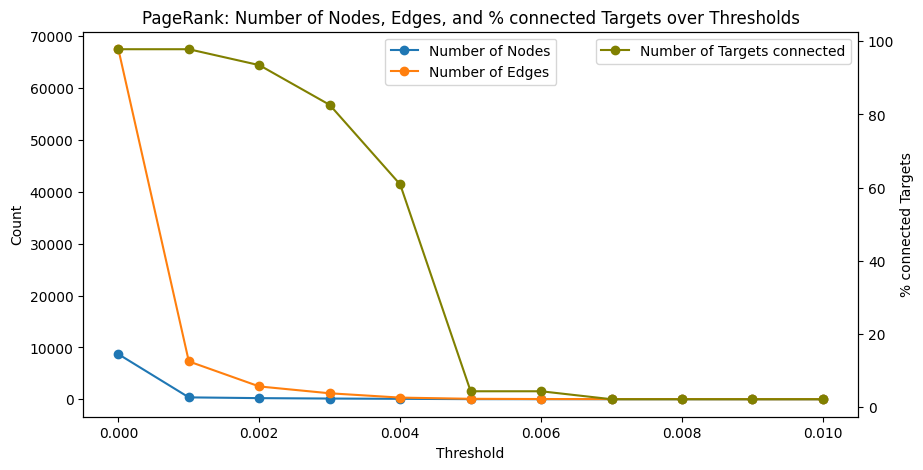

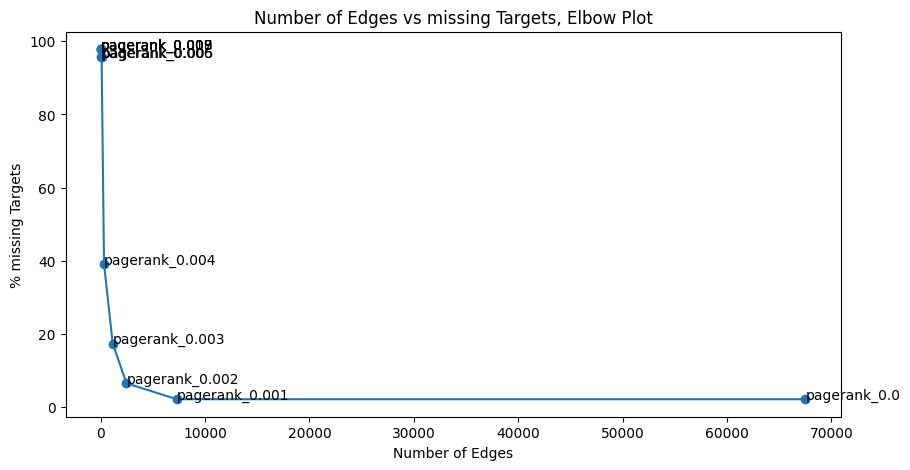

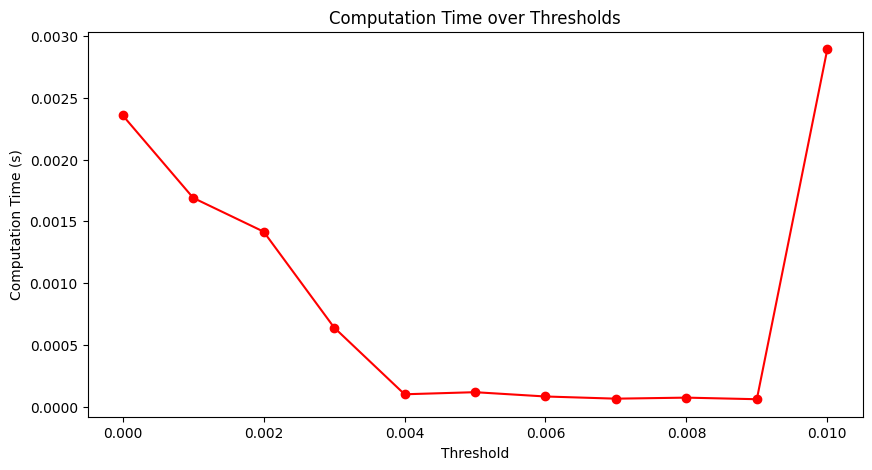

In [12]:
G2P_solver.visualize_qcplots(is_sign_consistent=False)

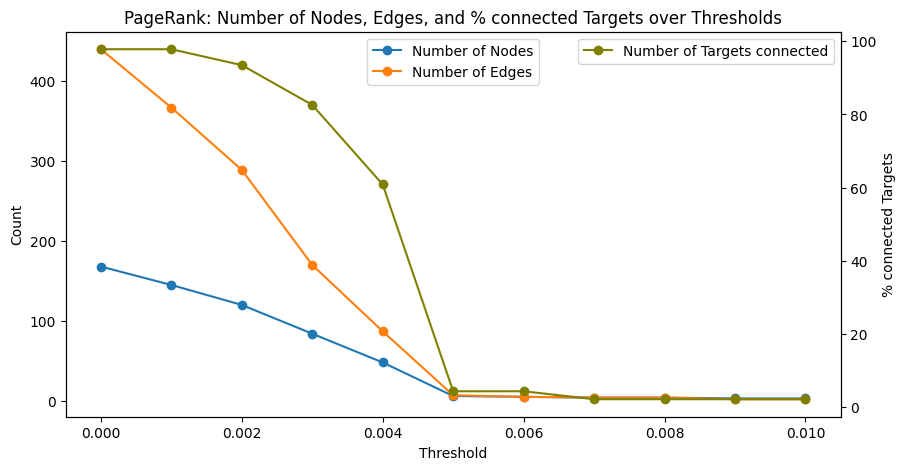

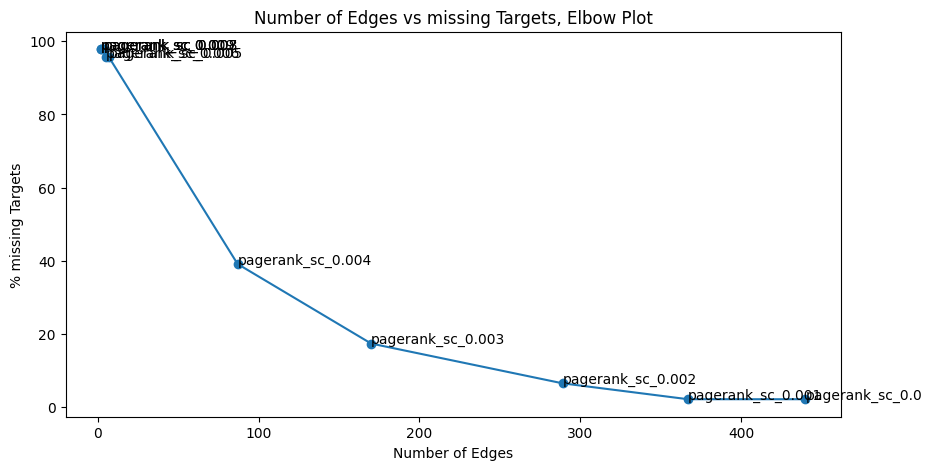

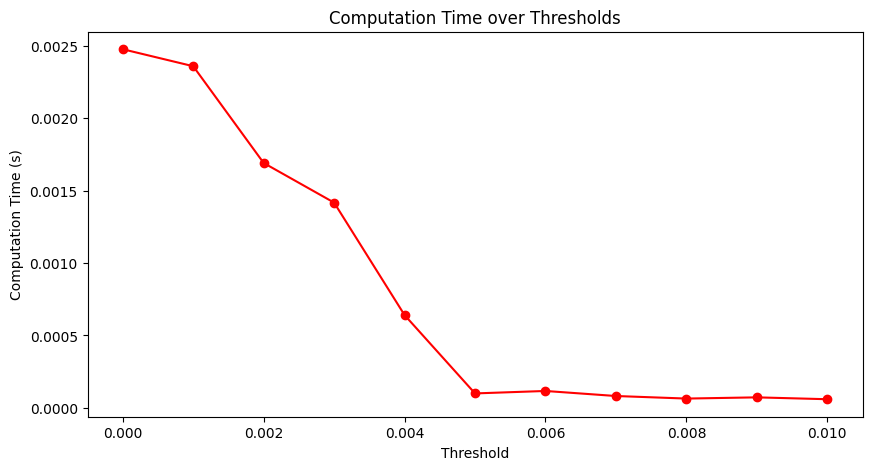

In [13]:
G2P_solver.visualize_qcplots(is_sign_consistent=True)

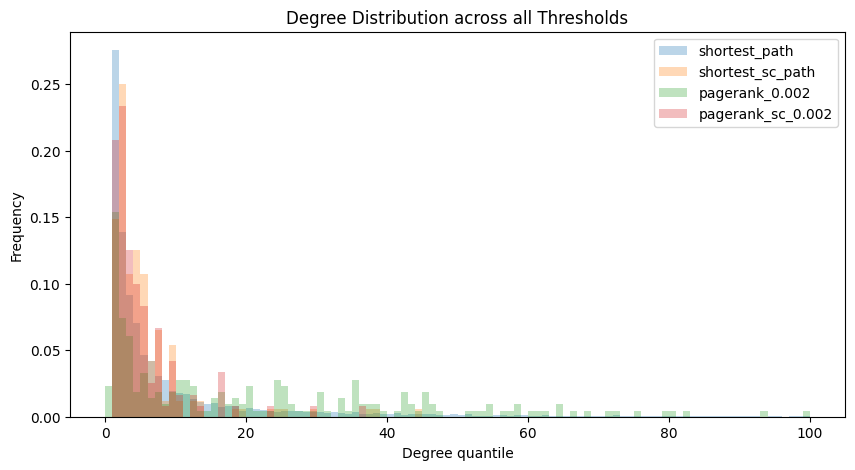

In [17]:
selected_thresholds = ['shortest_path', 'shortest_sc_path', 'pagerank_0.002', 'pagerank_sc_0.002']
G2P_solver.visualize_degrees(selected_thresholds, is_sign_consistent=False)
